In [72]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

import warnings

import requests, os, sys

if sys.version_info.major == 3:
    from io import StringIO
else:
    from StringIO import StringIO

import pyspark

warnings.filterwarnings('ignore')

%pylab inline
%config InlineBackend.figure_formats = ['retina']
sns.set(style="darkgrid")
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [73]:
df = pd.read_csv("hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [74]:
null_df = df.isnull().sum()
null_df[null_df>0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [75]:
# En yakın komşuyla doldurma
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")
df["children"] = imputer.fit_transform(df["children"].values.reshape(-1,1))

# Atılacaklar
df["children"] = df["children"].astype("int")

no_guest = list(df[((df["adults"]+df["babies"]+df["children"])==0)].index) # gelen giden yok?
df = df.drop(no_guest,axis=0) # 180 satırı uçurduk.

no_guest2 = list(df[(df["adults"]==0)&(df["babies"]>0)].index) # Bebeğe ayrı oda mı yok artık !
df = df.drop(no_guest2,axis=0)
df.info()

# En çok tekrar edenle (most frequently)
df["country"] = df["country"].fillna("Other")

# Null değerleri dolduralım.
df.agent = df.agent.fillna(0)

df.company = df.company.fillna(0)



df['is_true_room'] = 0 # rezerve edilen oda ile atanan oda aynı değilse bu da iptale sebep olabilir.
df.loc[ df['reserved_room_type'] == df['assigned_room_type'] , 'is_true_room'] = 1

# zamanla değişebilen bilgiler ve gereksiz özellikleri artık atalım  'days_in_waiting_list',
df = df.drop(columns=['assigned_room_type', 'booking_changes',
                                'reservation_status', 'reservation_status_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119207 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119207 non-null  object 
 1   is_canceled                     119207 non-null  int64  
 2   lead_time                       119207 non-null  int64  
 3   arrival_date_year               119207 non-null  int64  
 4   arrival_date_month              119207 non-null  object 
 5   arrival_date_week_number        119207 non-null  int64  
 6   arrival_date_day_of_month       119207 non-null  int64  
 7   stays_in_weekend_nights         119207 non-null  int64  
 8   stays_in_week_nights            119207 non-null  int64  
 9   adults                          119207 non-null  int64  
 10  children                        119207 non-null  int32  
 11  babies                          119207 non-null  int64  
 12  meal            

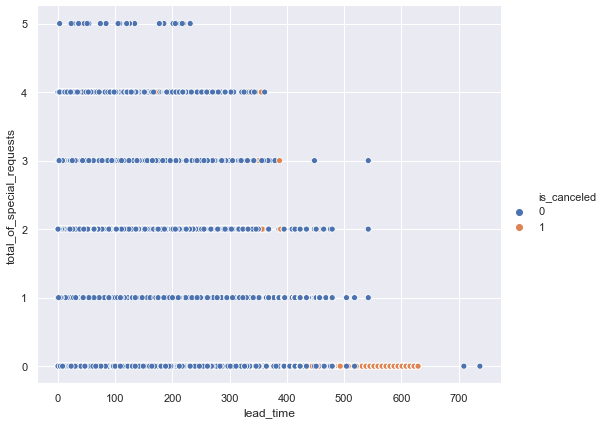

In [17]:
sns.relplot(x="lead_time", y="total_of_special_requests", hue="is_canceled", data=df,
           height=6, aspect=1.2)

Text(0.5, 1.0, 'Distribution of Lead Time')

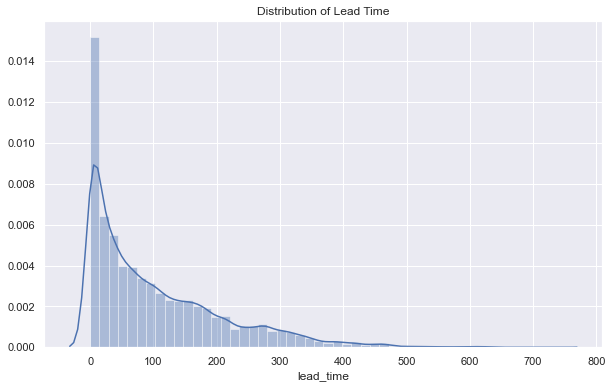

In [6]:
plt.figure(figsize=(10,6))
sns.distplot(df['lead_time']).set_title('Distribution of Lead Time')

C:\Users\istay\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


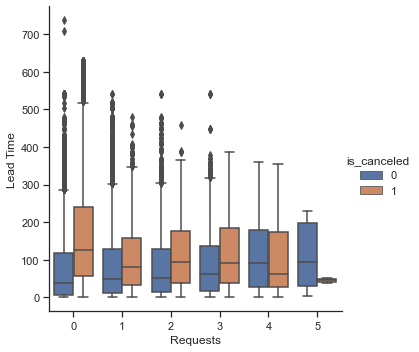

In [7]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("total_of_special_requests", "lead_time", "is_canceled", data=df, kind="box")
    g.set_axis_labels("Requests", "Lead Time");

In [76]:
df.children.unique()

array([ 0,  1,  2, 10,  3])

In [174]:
df.country.value_counts(ascending=False)

PRT    48481
GBR    12120
FRA    10401
ESP     8560
DEU     7285
       ...  
VGB        1
NIC        1
NPL        1
UMI        1
BDI        1
Name: country, Length: 178, dtype: int64

Text(0.5, 1.0, 'Zamana Bağlı Iptal Grafiği')

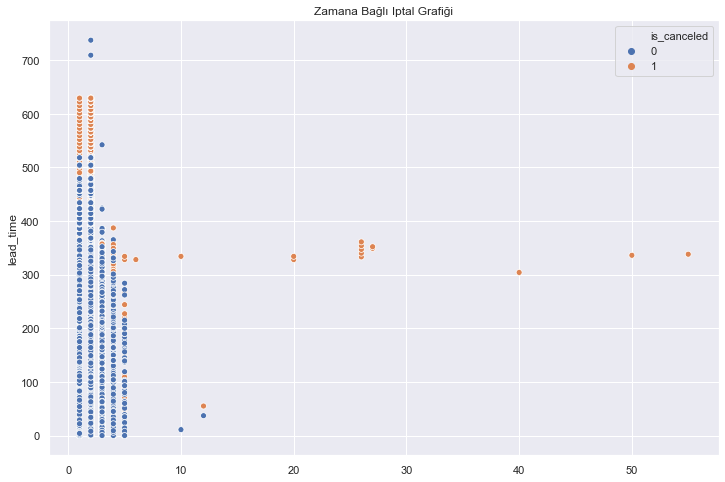

In [68]:
#Scatter plot
plt.figure(figsize=(12,8))
sns.scatterplot(x=df["adults"]+df["babies"]+df["children"], y="lead_time",hue="is_canceled", data=df).set_title("Zamana Bağlı Iptal Grafiği")

In [43]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Defa

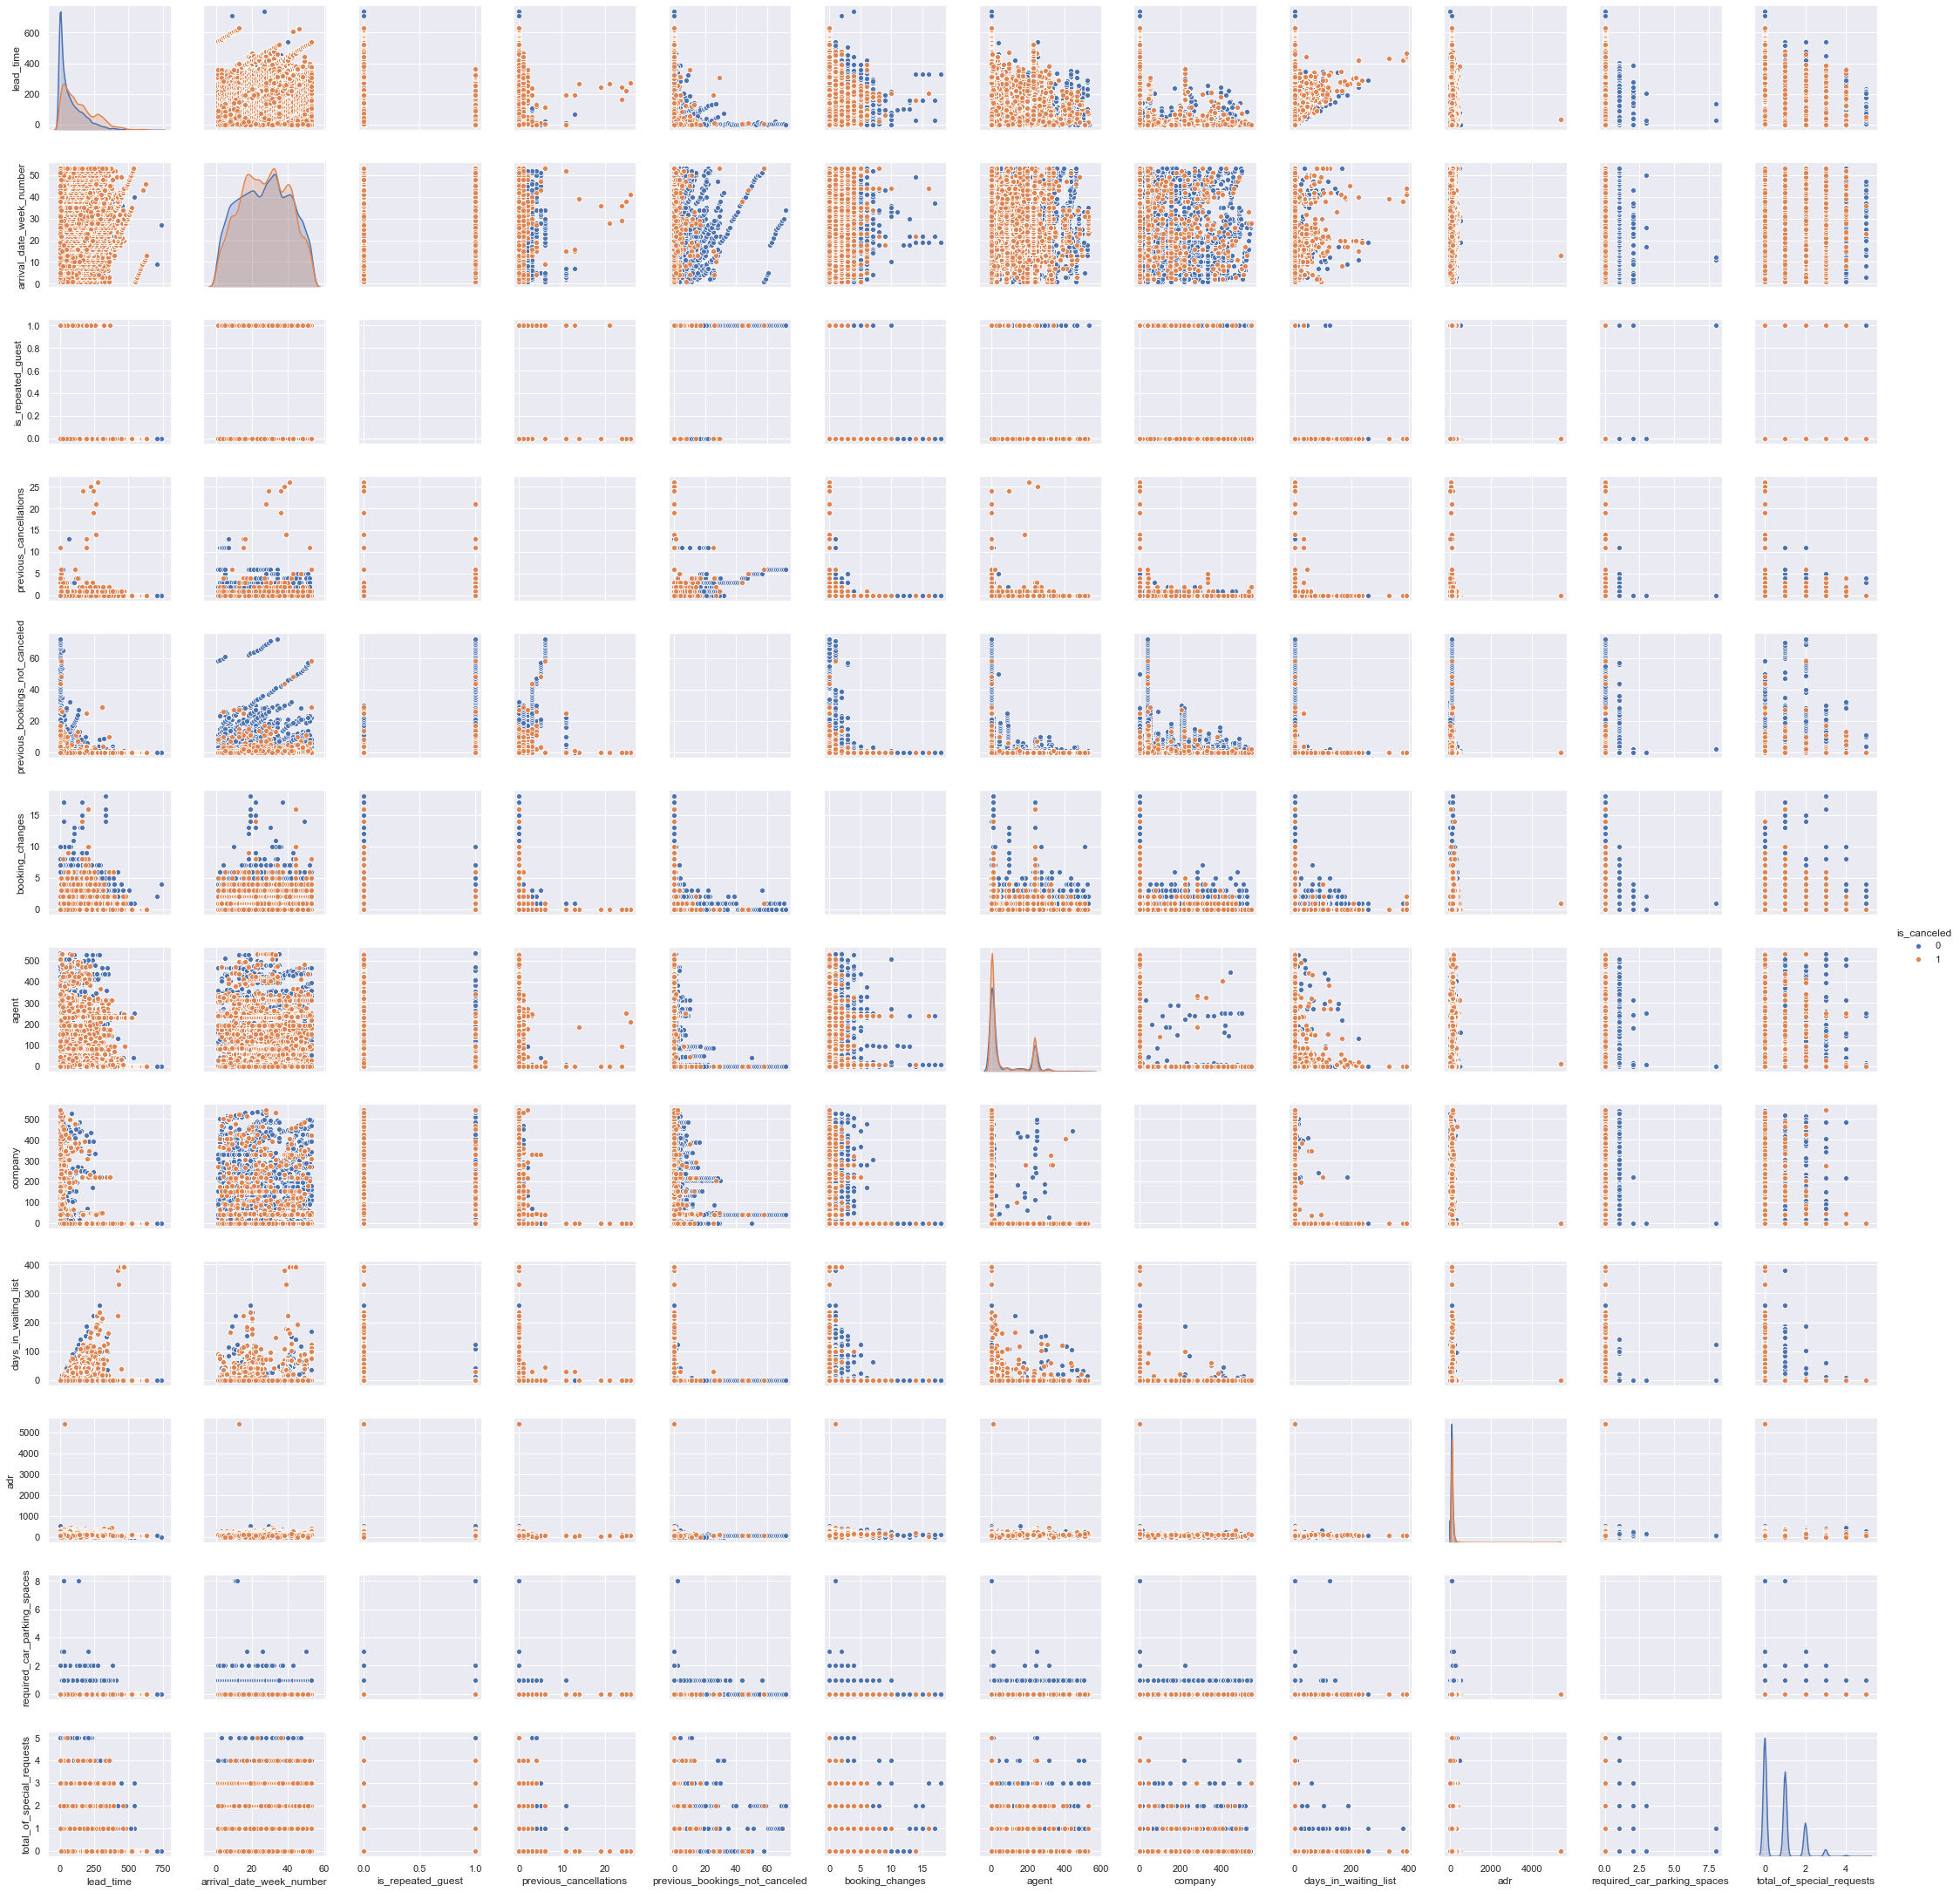

In [46]:
df1 = df[["lead_time", 'arrival_date_week_number',
       'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests','is_canceled']]
sns.pairplot(df1,hue="is_canceled")

In [97]:
df.country.nunique()

178

In [78]:
df.groupby("is_canceled").days_in_waiting_list.mean()

is_canceled
0    1.587729
1    3.566179
Name: days_in_waiting_list, dtype: float64

C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\istay\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Defa

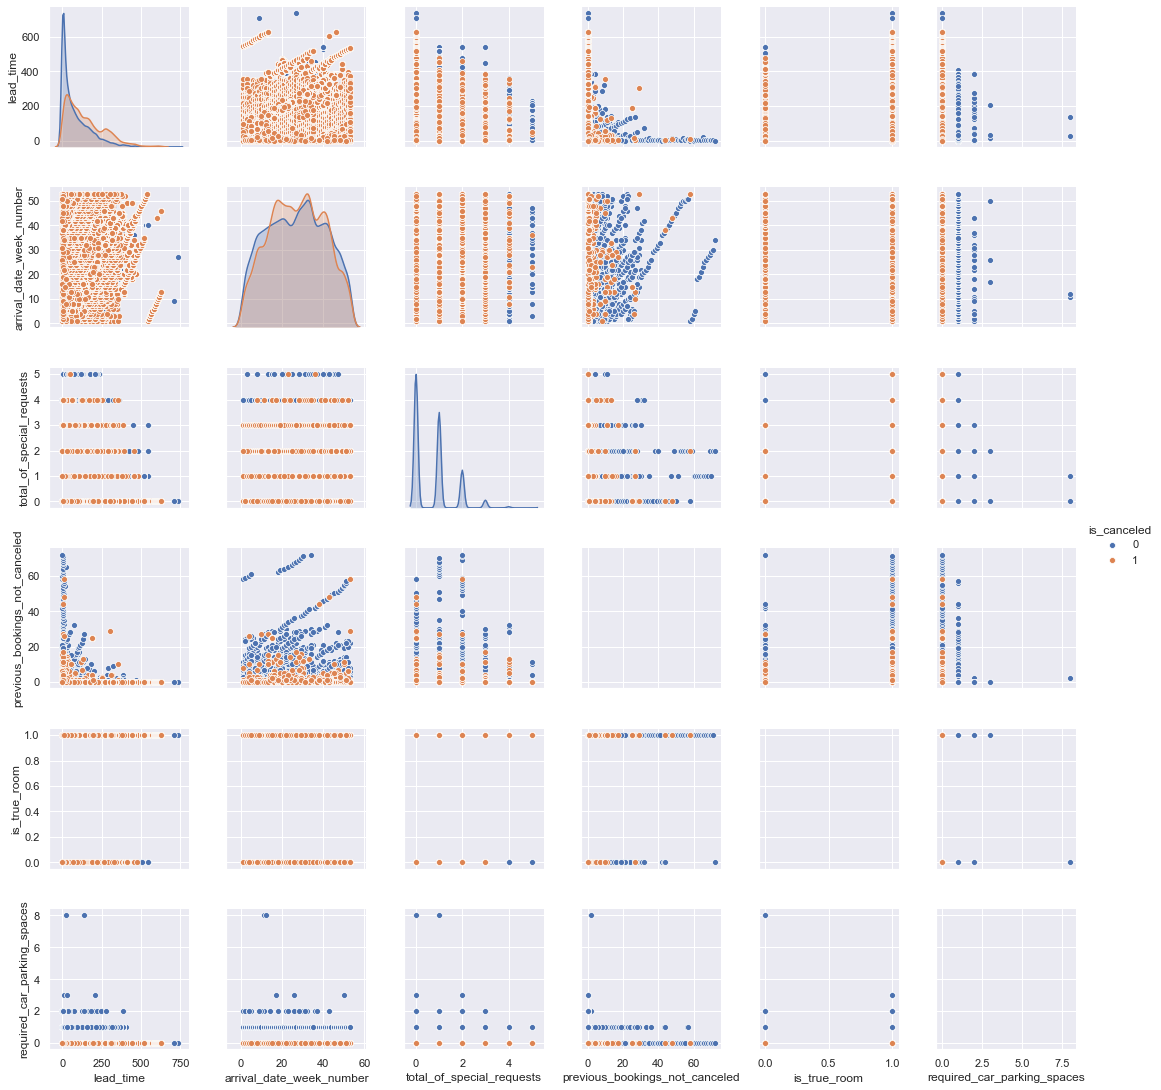

In [52]:
useful_cols = ["lead_time", 'arrival_date_week_number','total_of_special_requests',
               'previous_bookings_not_canceled',"is_true_room",'required_car_parking_spaces',"is_canceled"]
sns.pairplot(df[useful_cols],hue="is_canceled");

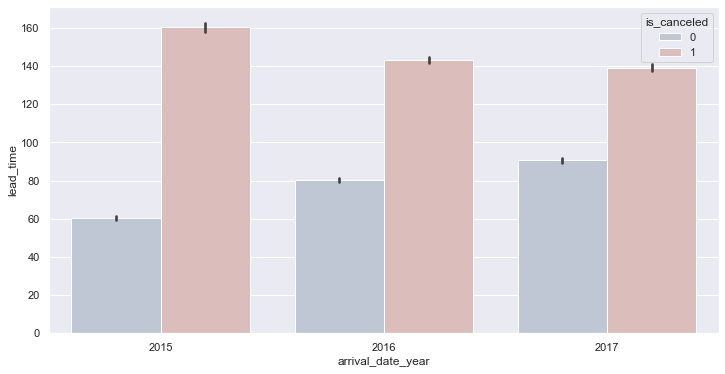

In [53]:
plt.figure(figsize=(12,6))
sns.barplot(x='arrival_date_year', y='lead_time',hue='is_canceled', data= df, palette='vlag')

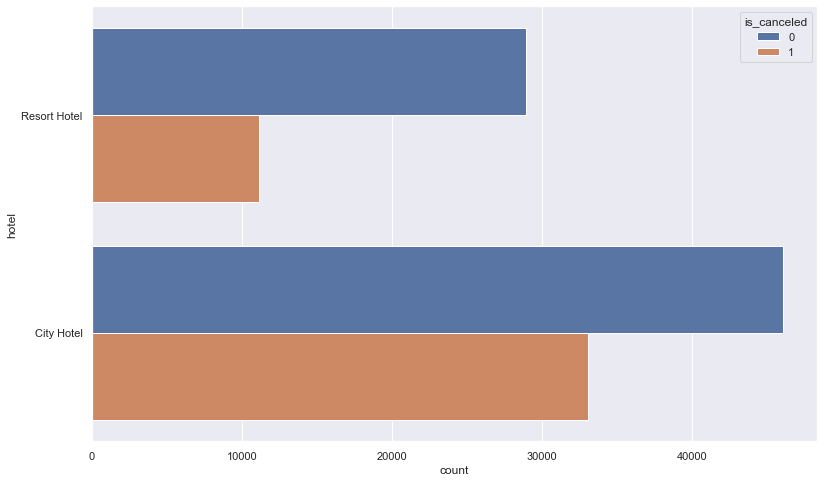

In [56]:
plt.figure(figsize=(13,8))
sns.countplot(y="hotel",hue='is_canceled',data=df)

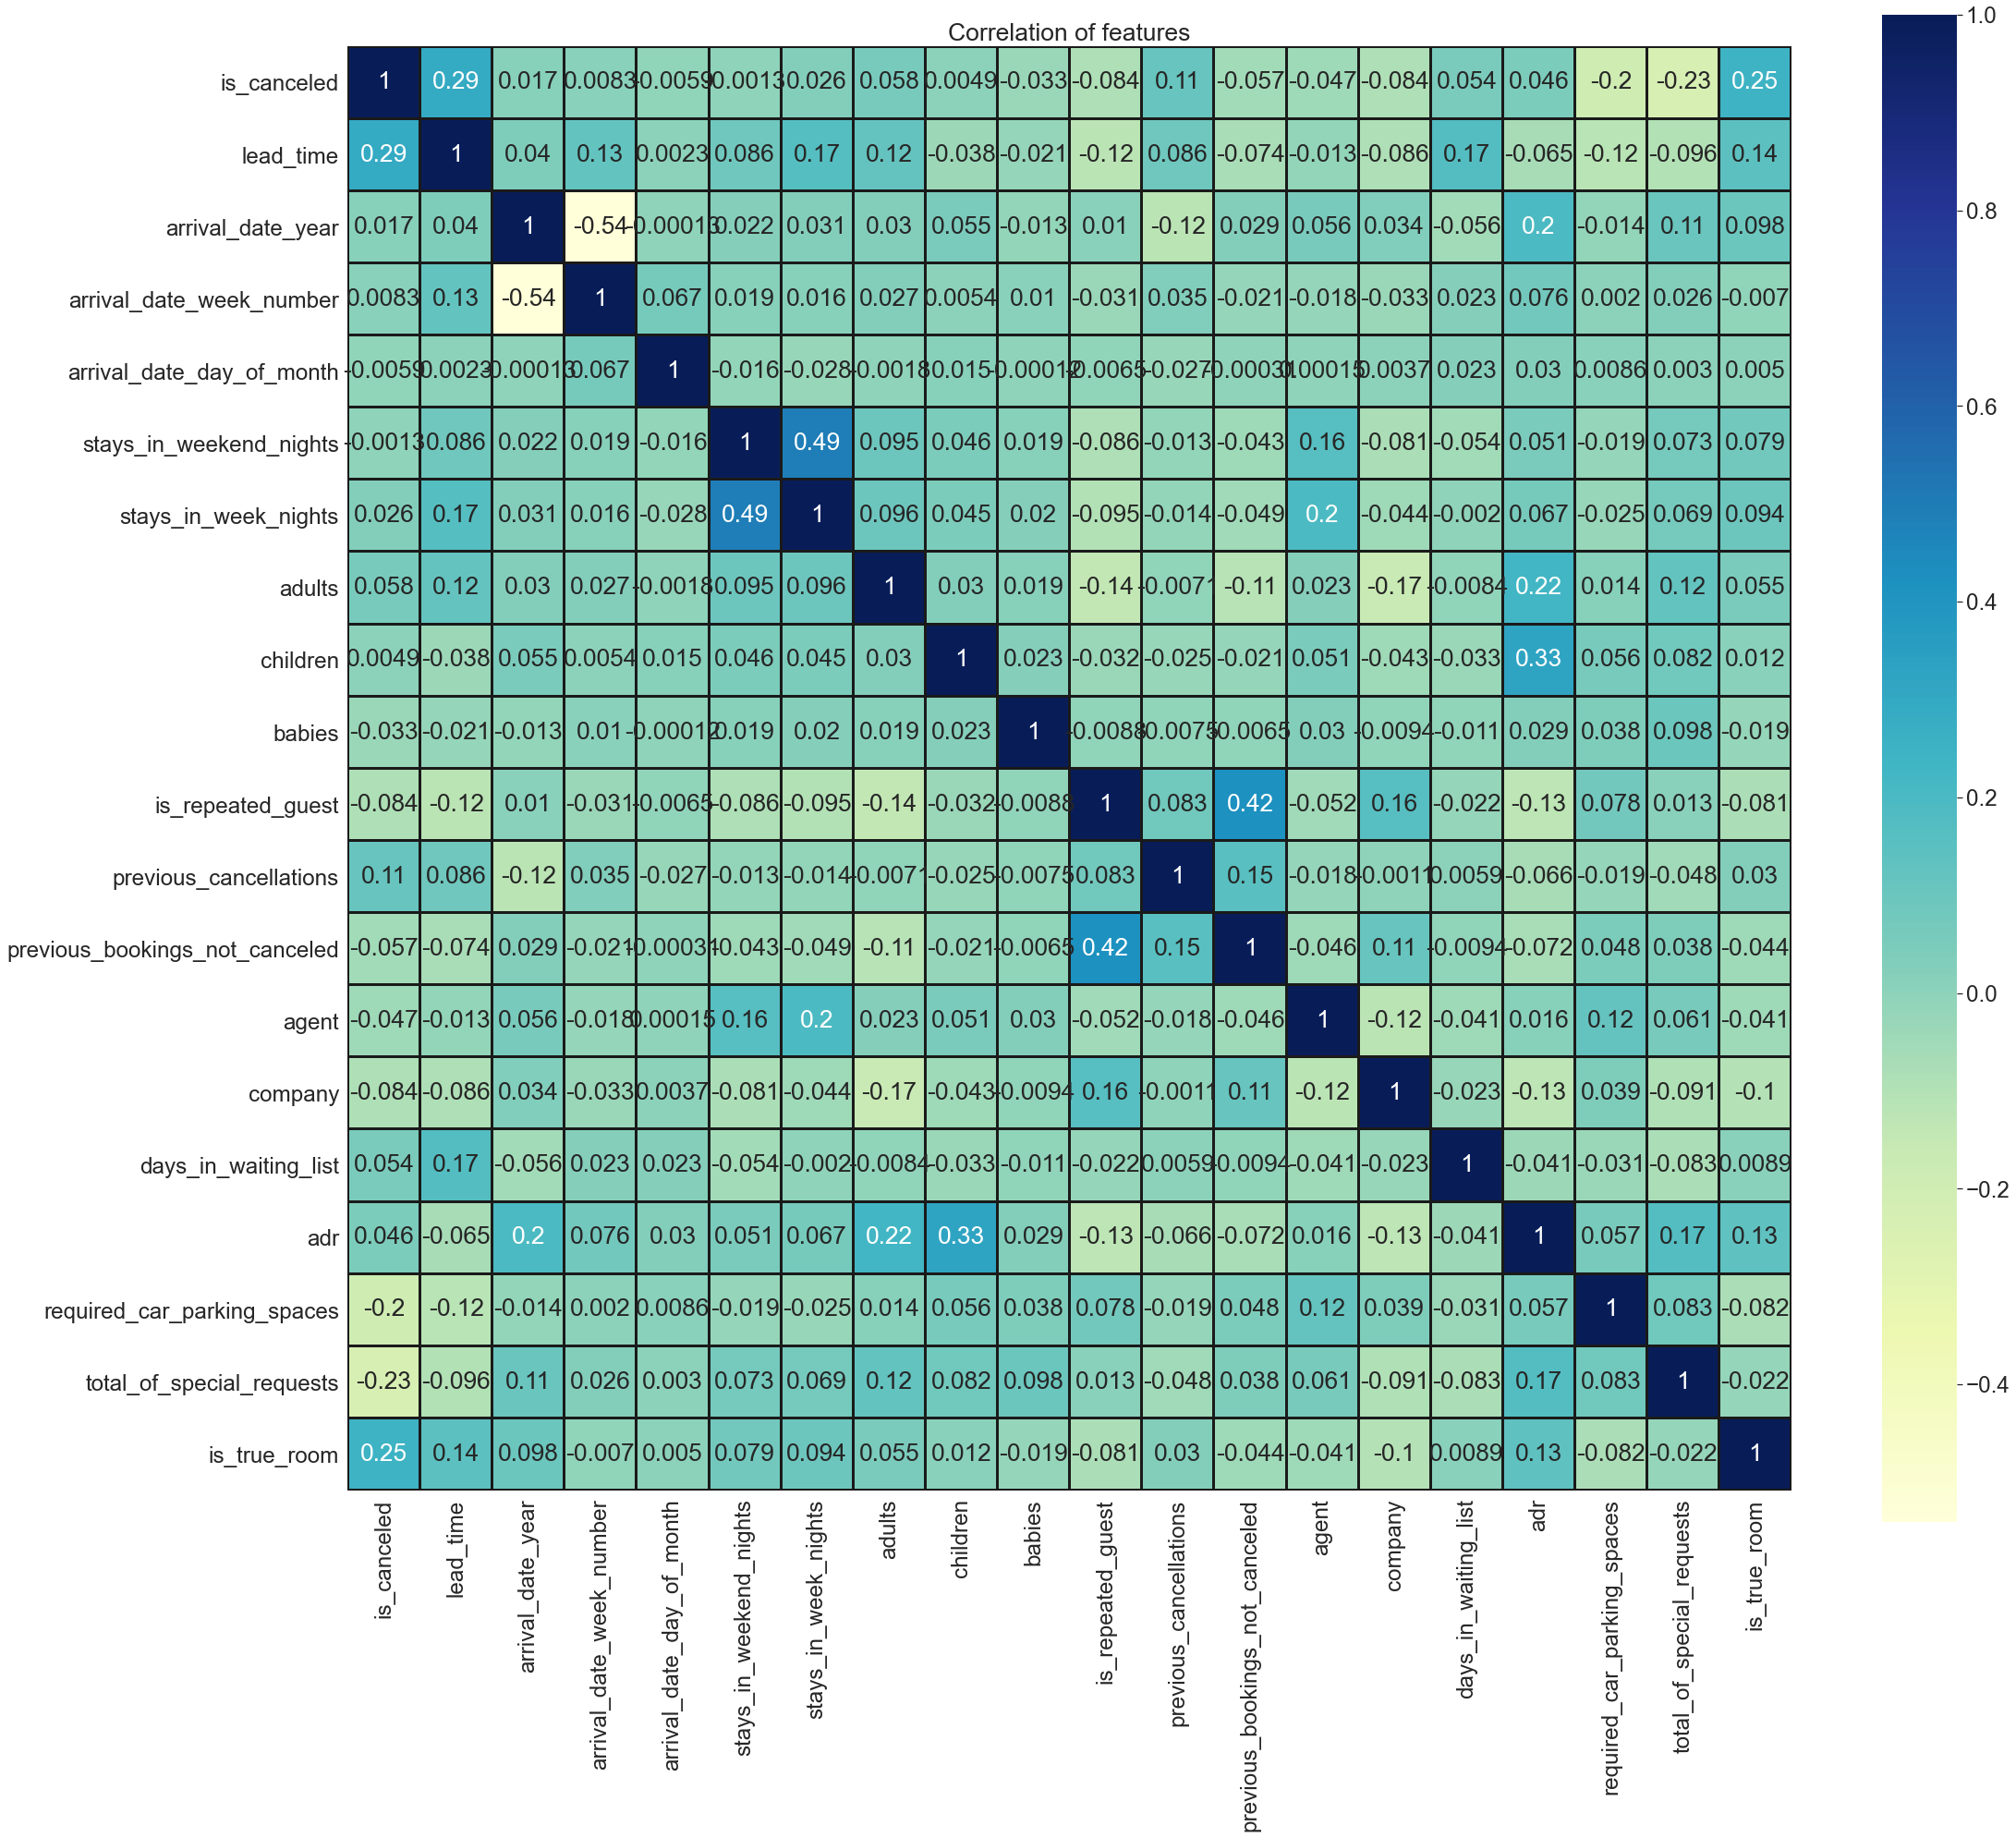

In [73]:
sns.set(font_scale=2.2)
fig,ax=plt.subplots(figsize=(35,30))
plt.title("Correlation of features")
sns.heatmap(df.corr(),linewidths=2.0,vmax=1.0,square=True,cmap="YlGnBu",linecolor="k",annot=True);
plt.savefig("corr.jpeg",dpi=300,bbox_inches="tight")

### Dealing With Categorical Data

In [79]:
obj = list(df.select_dtypes(include=["object"]).columns)
for o in obj:
    print(o+": ",df[o].unique(),"\n")

hotel:  ['Resort Hotel' 'City Hotel'] 

arrival_date_month:  ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June'] 

meal:  ['BB' 'FB' 'HB' 'SC' 'Undefined'] 

country:  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'Other' 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'ST

In [80]:
otel_map ={"Resort Hotel":1,"City Hotel":2}
df.hotel = df.hotel.map(otel_map)

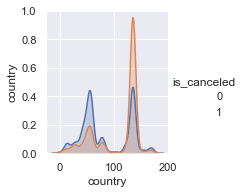

In [119]:
col_label = ["country"]

from sklearn import preprocessing
df2 = df.copy()
for col in col_label:
    le = preprocessing.LabelEncoder()
    df2[col] = le.fit_transform(df2[col])
sns.pairplot(df2[["country","is_canceled"]],hue="is_canceled");

## Veriyi Tanıyalım

In [88]:
df.describe()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_true_room
count,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000,85762.000000
mean,1.609851,0.275588,79.104708,2016.213999,26.800949,15.799585,1.007976,2.628134,1.883072,0.140692,0.010972,0.039108,0.030538,0.187041,81.205056,10.614736,0.655384,106.819413,0.085492,0.705091,0.853886
std,0.487786,0.446813,85.345890,0.684764,13.658232,8.843338,1.028679,2.044492,0.622243,0.459003,0.114415,0.193854,0.371985,1.747492,109.911108,53.083579,9.288194,55.104130,0.283466,0.833172,0.353222
min,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,11.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,72.250000,0.000000,0.000000,1.000000
50%,2.000000,0.000000,49.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,99.000000,0.000000,1.000000,1.000000
75%,2.000000,1.000000,124.000000,2017.000000,37.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,0.000000,0.000000,134.830000,0.000000,1.000000,1.000000
max,2.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,1.000000


In [81]:
df.is_canceled.value_counts() 

0    75009
1    44198
Name: is_canceled, dtype: int64

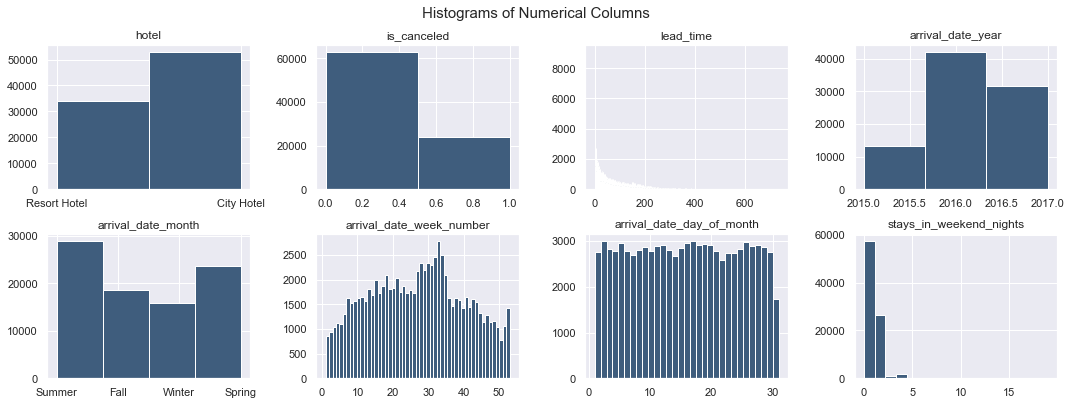

In [110]:
f = plt.figure(figsize=(15,6))
f.suptitle('Histograms of Numerical Columns', fontsize=15)
sizee = len(df.select_dtypes(include=["object"]).columns)

for i in range(1, 9):    
    plt.subplot(2, 4, i)
    #get current plot axes
    f = plt.gca()
#     f.axes.get_yaxis().set_visible(False)
    #set column name as title
    f.set_title(df.columns.values[i - 1])

    vals = np.size(df.iloc[:, i - 1].unique())
    
    plt.hist(df.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

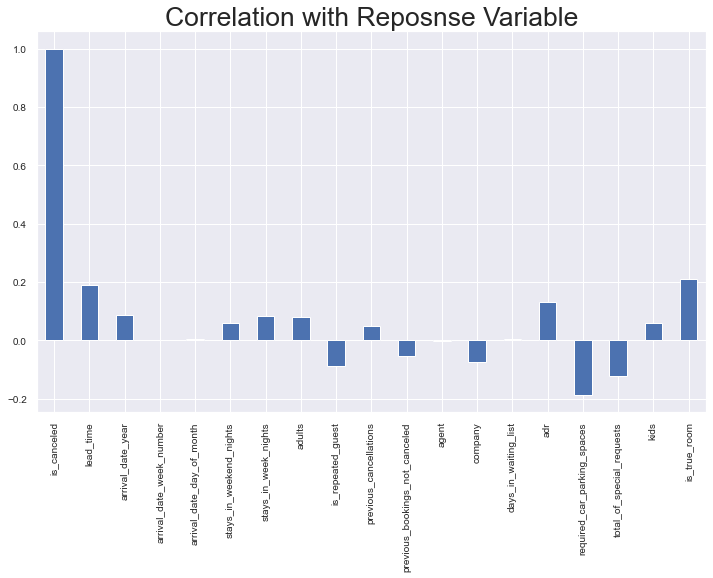

In [434]:
df.corrwith(df.is_canceled).plot.bar(figsize=(12, 7),
                  title = 'Correlation with Reposnse Variable',
                  fontsize = 10, rot = 90,
                  grid = True)

In [435]:
col_corr = ["distribution_channel","deposit_type","customer_type","meal"]

(pd.get_dummies(df[col_corr])).corr() # Dummy Trap !

,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined
distribution_channel_Corporate,1.000000,-0.102658,-0.011178,-0.478125,-0.001872,-0.013146,0.014959,-0.003811,-0.042705,-0.001551,-0.082222,0.117450,0.113582,-0.005217,-0.068213,-0.081764,-0.008392
distribution_channel_Direct,-0.102658,1.000000,-0.019106,-0.817222,-0.003199,0.017685,-0.029868,0.036198,-0.078142,0.013624,0.059746,-0.026500,0.073604,0.024040,0.000351,-0.109829,0.028646
distribution_channel_GDS,-0.011178,-0.019106,1.000000,-0.088983,-0.000348,0.005212,-0.004972,-0.001543,-0.008851,-0.003621,0.020432,-0.017205,-0.022042,-0.002899,-0.015445,0.045764,-0.003272
distribution_channel_TA/TO,-0.478125,-0.817222,-0.088983,1.000000,-0.014899,-0.008639,0.018274,-0.029430,0.093943,-0.010659,-0.007669,-0.041992,-0.126841,-0.017799,0.040227,0.137905,-0.019991
distribution_channel_Undefined,-0.001872,-0.003199,-0.000348,-0.014899,1.000000,0.000873,-0.000832,-0.000258,-0.001482,-0.000606,-0.012954,0.015619,0.000384,-0.000485,0.002441,-0.002669,-0.000548
deposit_type_No Deposit,-0.013146,0.017685,0.005212,-0.008639,0.000873,1.000000,-0.954075,-0.296049,0.005588,0.002517,0.018936,-0.025159,-0.018960,-0.022139,-0.007937,0.037942,-0.001945
deposit_type_Non Refund,0.014959,-0.029868,-0.004972,0.018274,-0.000832,-0.954075,1.000000,-0.003688,-0.004949,-0.008654,-0.000784,0.005755,0.015767,0.023852,0.010833,-0.037057,0.002797
deposit_type_Refundable,-0.003811,0.036198,-0.001543,-0.029430,-0.000258,-0.296049,-0.003688,1.000000,-0.002873,0.019191,-0.060711,0.065633,0.013018,-0.002150,-0.008047,-0.008497,-0.002427
customer_type_Contract,-0.042705,-0.078142,-0.008851,0.093943,-0.001482,0.005588,-0.004949,-0.002873,1.000000,-0.015407,-0.433225,-0.073207,-0.011672,-0.007410,0.052517,-0.033786,-0.001689
customer_type_Group,-0.001551,0.013624,-0.003621,-0.010659,-0.000606,0.002517,-0.008654,0.019191,-0.015407,1.000000,-0.177222,-0.029947,0.016610,-0.002711,-0.009852,-0.011607,-0.001552


In [149]:
obj = list(df.select_dtypes(include=["object"]).columns)
for o in obj:
    print(o+": ",df[o].unique(),"\n")

arrival_date_month:  ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June'] 

meal:  ['BB' 'FB' 'HB' 'SC' 'Undefined'] 

country:  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'NULL' 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA'
 'KHM' '

In [82]:
col = ["market_segment","distribution_channel","deposit_type","customer_type","meal","arrival_date_month"]


df = pd.concat([pd.get_dummies(df[col]),df],axis=1) 
df = df.drop(columns=col)

In [83]:
df = df.drop(columns=["distribution_channel_Direct","deposit_type_No Deposit","customer_type_Transient-Party"]) # dummy trap !

In [84]:
col_label = ['reserved_room_type',"country"]
# ,"country"
from sklearn import preprocessing

for col in col_label:
    le = preprocessing.LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [85]:
df['reserved_room_type'].unique()

array([2, 0, 3, 4, 6, 5, 7, 8, 1])

In [96]:
df.select_dtypes(include=["object"]).columns[10:-10]

Index([], dtype='object')

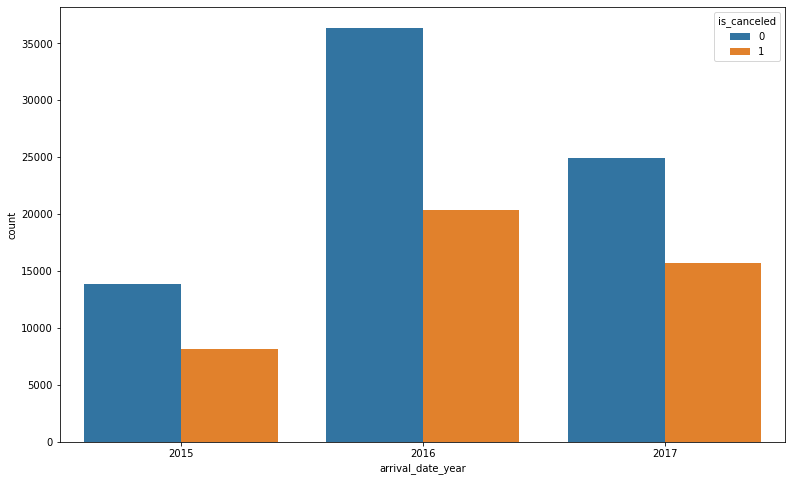

In [349]:
plt.figure(figsize=(13,8))
sns.countplot(x='arrival_date_year',hue='is_canceled',data=df)

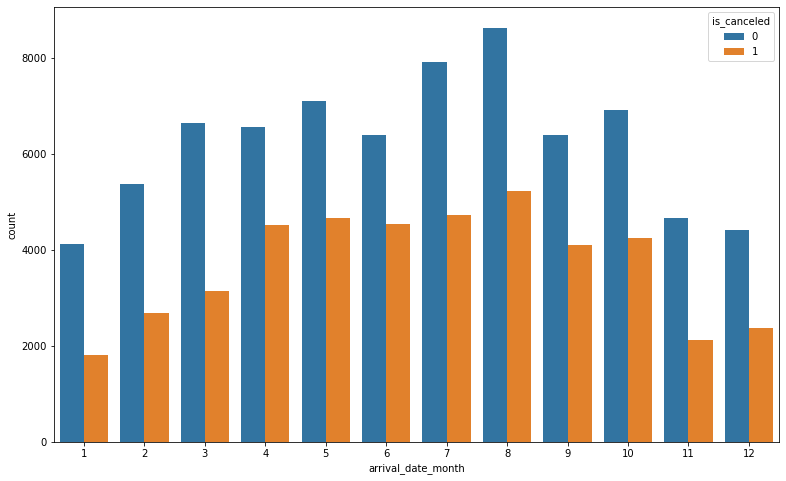

In [351]:
plt.figure(figsize=(13,8))
sns.countplot(x='arrival_date_month',hue='is_canceled',data = df)

In [86]:
df.to_csv("ready_for_model.csv")